In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import os
import sys
import time
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
K.set_epsilon(1e-08)
print('[INFO] Using keras {0}'.format(keras.__version__))

import tensorflow as tf
print('[INFO] Using tensorflow {0}'.format(tf.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

#import pandas as pd
#import statsmodels

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# ______________________________________________________________________________
# Globals
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.12.npz'

infile2 = '../test2/histos_tbd.12.npz'


[INFO] Using numpy 1.12.1


Using TensorFlow backend.


[INFO] Using keras 2.0.5
[INFO] Using tensorflow 1.1.0
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    at_least_10_GeV = np.abs(the_parameters[:,0]) < 0.1  # at least 10 GeV 
    the_variables = the_variables[at_least_10_GeV]
    the_parameters = the_parameters[at_least_10_GeV]
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (792798, 76)
[INFO] Loaded the parameters with shape (792798, 3)


In [3]:
#### Load data (pileup) ####

try:
    loaded_2 = np.load(infile2)
    the_variables_2 = loaded_2['variables']
    only_train_50_percent = the_variables_2.shape[0]//2
    the_variables_2 = the_variables_2[:only_train_50_percent]  # 50% events for training
    the_parameters_2 = np.zeros((only_train_50_percent, 3), dtype=np.float32)
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile2))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables_2.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters_2.shape))

[INFO] Loaded the variables with shape (242266, 76)
[INFO] Loaded the parameters with shape (242266, 3)


In [4]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 6) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_ring  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_fr    = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_mask  = self.x_copy[:, nlayers*5:nlayers*6].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*6:nlayers*7]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis].astype(np.int32)
      self.x_zone         = self.x_road[:, 1][:, np.newaxis].astype(np.int32)
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # adjust by hand
        self.x_phi   *= 0.000991  # GE1/1 dphi linear correlation with q/pT
        self.x_theta *= (1/12.)   # 12 integer theta units
        self.x_bend  *= 0.188082  # ME1/2 bend linear correlation with q/pT
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        np.place(self.x_ring, x_ring_tmp, 0)  # ring 1,4 -> 0
        np.place(self.x_ring, ~x_ring_tmp, 1) # ring 2,3 -> 1
        #self.x_fr     = self.x_fr
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        theta_cuts   *= (1/12.)   # 12 integer theta units
        assert(len(theta_cuts) == nlayers)
        x_theta_tmp = np.abs(self.x_theta) > theta_cuts
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_ring [x_theta_tmp] = np.nan
      self.x_fr   [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness /= np.max(self.x_straightness)
      self.x_zone         /= np.max(self.x_zone)
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_ring, self.x_fr, self.x_mask, self.x_straightness, self.x_zone, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_zone(self):
    x_zone = self.x_zone.copy()
    return x_zone

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

In [5]:
#### Prepare data ####

# Preprocess data
encoder_1 = Encoder(the_variables, the_parameters, adjust_scale=2)
x_1, y_1, w_1, x_mask_1 = encoder_1.get_x(), encoder_1.get_y(), encoder_1.get_w(), encoder_1.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train_1, x_test_1, y_train_1, y_test_1, w_train_1, w_test_1, x_mask_train_1, x_mask_test_1 = train_test_split(x_1, y_1, w_1, x_mask_1, test_size=0.4)

nvariables = x_train_1.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


[INFO] Using 80 variables and 1 parameters


In [6]:
print x_1, y_1, w_1
print np.mean(x_1, axis=0)
print np.std(x_1, axis=0)
print np.isfinite(x_1).all()

[[ 0.        0.007928  0.003964 ...,  1.        1.        1.      ]
 [ 0.       -0.031712  0.       ...,  1.        1.        1.      ]
 [ 0.       -0.003964  0.       ...,  1.        1.        1.      ]
 ..., 
 [ 0.        0.007928 -0.007928 ...,  1.        1.        1.      ]
 [ 0.03964   0.        0.       ...,  1.        1.        1.      ]
 [ 0.044595  0.       -0.007928 ...,  1.        1.        1.      ]] [ 0.01238597 -0.07262506 -0.00417533 ...,  0.04690636  0.06029635
  0.05258178] [ 1.06192982  1.36312532  1.02087665 ...,  1.23453176  1.30148172
  1.26290894]
[ -1.81152829e-03  -1.22222306e-03  -2.83998712e-03  -2.92855108e-03
  -2.91659480e-03  -1.02961257e-03  -1.06128766e-03  -2.46511618e-03
  -2.61548155e-03  -1.26145816e-03  -1.27123819e-03   0.00000000e+00
   2.78479415e-02   2.67953929e-03   3.69997568e-05  -9.72478727e-03
  -2.43042161e-03  -8.17442387e-03  -1.66230873e-03   2.18330103e-03
   1.89153379e-02   1.66914106e-02   2.40229336e-02   0.00000000e+00
  -1.79114

In [7]:
#### Prepare data (pileup) ####

# Preprocess data
encoder_2 = Encoder(the_variables_2, the_parameters_2, adjust_scale=2)
x_2, y_2, w_2, x_mask_2 = encoder_2.get_x(), encoder_2.get_y(), encoder_2.get_w(), encoder_2.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train_2, x_test_2, y_train_2, y_test_2, w_train_2, w_test_2, x_mask_train_2, x_mask_test_2 = train_test_split(x_2, y_2, w_2, x_mask_2, test_size=0.0)  # no train/test split

nvariables = x_train_2.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


[INFO] Using 80 variables and 1 parameters


In [8]:
print x_2, y_2, w_2
print np.mean(x_2, axis=0)
print np.std(x_2, axis=0)
print np.isfinite(x_2).all()

[[-0.13874     0.          0.047568   ...,  1.          1.          1.        ]
 [ 0.          0.057478    0.         ...,  0.          1.          1.        ]
 [ 0.          0.105046    0.         ...,  1.          1.          1.        ]
 ..., 
 [ 0.         -0.045586    0.         ...,  0.          1.          1.        ]
 [ 0.          0.         -0.025766   ...,  1.          1.          1.        ]
 [-0.28639901  0.          0.03964    ...,  1.          1.          0.        ]] [ 0.  0.  0. ...,  0.  0.  0.] [ 1.  1.  1. ...,  1.  1.  1.]
[  6.67360562e-03  -6.26630588e-04  -4.49767287e-03  -4.18603881e-03
  -5.38000342e-03  -8.16014648e-04  -1.55260729e-04  -5.90574892e-03
  -4.36819485e-03   1.91911602e-03  -2.57373819e-03   0.00000000e+00
   9.32463377e-02   2.35084238e-02  -5.55398492e-03  -3.10856670e-02
  -3.99707013e-02   3.42825663e-02   1.24919514e-02  -9.79560373e-02
  -3.85241165e-02   2.99195933e-02   2.08245625e-02   0.00000000e+00
   9.57388646e-03   8.81151567e-04  

In [9]:
# LeakyReLU with fix
# https://github.com/keras-team/keras/pull/7784

from keras.engine import Layer
from keras import backend as K

class MyLeakyReLU(Layer):
    """Leaky version of a Rectified Linear Unit.
    It allows a small gradient when the unit is not active:
    `f(x) = alpha * x for x < 0`,
    `f(x) = x for x >= 0`.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        alpha: float >= 0. Negative slope coefficient.
    # References
        - [Rectifier Nonlinearities Improve Neural Network Acoustic Models](https://web.stanford.edu/~awni/papers/relu_hybrid_icml2013_final.pdf)
    """

    def __init__(self, alpha=0.3, **kwargs):
        super(MyLeakyReLU, self).__init__(**kwargs)
        self.supports_masking = True
        if isinstance(alpha, dict):
            self.alpha = K.cast_to_floatx(alpha['value'])
        else:
            self.alpha = K.cast_to_floatx(alpha)

    def call(self, inputs):
        return K.relu(inputs, alpha=self.alpha)

    def get_config(self):
        config = {'alpha': float(self.alpha)}
        base_config = super(MyLeakyReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [10]:
#### Create a model ####

model = Sequential()
model.add(Dense(64, input_dim=nvariables, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
model.add(MyLeakyReLU(alpha=0.2))
model.add(Dropout(0.4))

model.add(Dense(64, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
model.add(MyLeakyReLU(alpha=0.2))
model.add(Dropout(0.4))
 
model.add(Dense(1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
model.add(Activation('sigmoid'))

# Set loss and optimizer
adam = optimizers.Adam(lr=0.0001)
rmsprop = optimizers.RMSprop(lr=0.0001)

# Compile
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])


In [11]:
print x_train_1.shape, x_test_1.shape
print x_train_2.shape, x_test_2.shape

(475678, 80) (317120, 80)
(242266, 80) (0, 80)


In [12]:
#### Training ####

def train():
  epochs = int(20000 * 1.6)
  batch_size = 256
  save_interval = 200

  for epoch in xrange(epochs):
    real = x_train_1[np.random.randint(0, x_train_1.shape[0], batch_size)]
    fake = x_train_2[np.random.randint(0, x_train_2.shape[0], batch_size)]
    
    # Also add random noise?

    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)

    x_train_batch = np.concatenate((real, fake))
    y_train_batch = np.concatenate((ones, zeros))

    d_loss = model.train_on_batch(x_train_batch, y_train_batch)

    if epoch % save_interval == 0:
      print "%d/%d - loss: %f - accuracy: %f" % (epoch, epochs, d_loss[0], d_loss[1])


# The webpage can become very unresponsive when you train with a large dataset with the above comment.
# So I do the following instead.
# See issue https://github.com/jupyter/notebook/issues/1474

start_time = time.time()
old_stdout = sys.stdout
sys.stdout = open('keras_output.txt', 'w')
train()
sys.stdout.close()
sys.stdout = old_stdout
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))
  
# Store model to file
model.summary()
model.save('model_discr.h5')
model.save_weights('model_discr_weights.h5')

# Store model to json
import json
with open('model_discr.json', 'w') as outfile:
  json.dump(model.to_json(), outfile)
  
print('[INFO] Model is saved as model_discr.h5, model_discr.json and model_discr_weights.h5')

[INFO] Time elapsed: 161.879853964 sec
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                5184      
_________________________________________________________________
my_leaky_re_lu_1 (MyLeakyReL (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
my_leaky_re_lu_2 (MyLeakyReL (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1

In [13]:
#### Evaluation using Keras internal tool ####



Welcome to JupyROOT 6.10/05


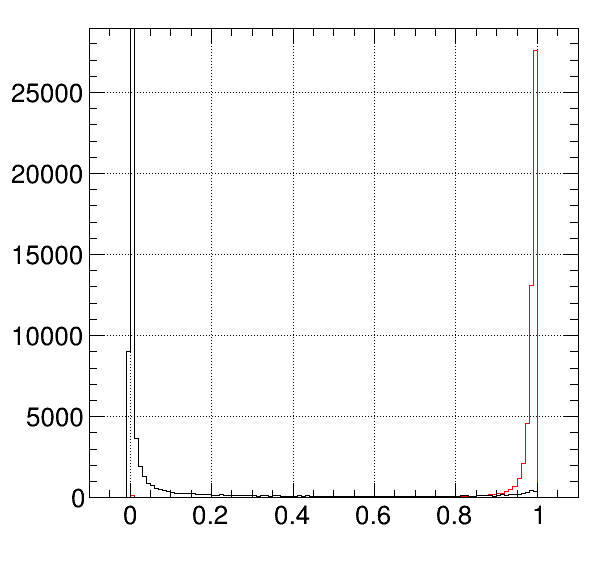

In [14]:
#### Application ####

from keras.models import load_model
import ROOT

# Load model
loaded_model = load_model('model_discr.h5', custom_objects={'MyLeakyReLU': MyLeakyReLU})
loaded_model.load_weights('model_discr_weights.h5')

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1a = ROOT.TH1F("h1a", "h1b", 120, -0.1, 1.1)
h1b = ROOT.TH1F("h1b", "h1b", 120, -0.1, 1.1)

nentries_test_1 = x_test_1.shape[0]/6

y_test_true_1 = np.ones(nentries_test_1)
y_test_pred_1 = loaded_model.predict(x_test_1[:nentries_test_1, :])

# Loop over events
for i in xrange(nentries_test_1):
  h1a.Fill(y_test_pred_1[i])


x_test_2 = x_train_2  # no train/test split  

nentries_test_2 = x_test_2.shape[0]/1

y_test_true_2 = np.zeros(nentries_test_2)
y_test_pred_2 = loaded_model.predict(x_test_2[:nentries_test_2, :])

# Loop over events
for i in xrange(nentries_test_2):
  h1b.Fill(y_test_pred_2[i])


# Draw
c = ROOT.TCanvas()
h1a.SetLineColor(632)  # kRed
h1a.Draw()
h1b.SetLineColor(1)  # kBlack
h1b.Draw("same")
c.Draw()

(0.9, 1.0)

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-njopjo/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


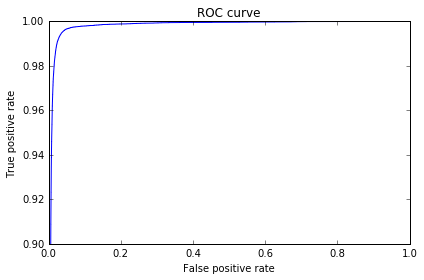

In [15]:
from sklearn.metrics import roc_curve

y_test_true = np.concatenate((y_test_true_1, y_test_true_2))
y_test_pred = np.concatenate((y_test_pred_1, y_test_pred_2))

fpr, tpr, _ = roc_curve(y_test_true, y_test_pred)

fig, ax = plt.subplots(tight_layout=True)
ax.plot(fpr, tpr)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.9,1.0])